## Timeseries analysis of StatsNZ trade data

In this notebook, I will examine the StatsNZ trade data between January 2014 and September 2022. The trade data includes values of exports and imports for goods and services in NZ$. Exports and imports are listed per country and per 2-digits Harmonised Classification codes.  

The table is available from the Stats NZ trade website: 
<a href="https://statisticsnz.shinyapps.io/trade_dashboard/">Stats NZ Trade Dashboard</a>

#### Data loading

In [1]:
#import python libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

#set plotting style and size

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16,6]

In [2]:
#read data into dataframe df

file = '../data/Tradedata.csv'

quarter_date_parser = lambda x: datetime.strptime(x, "%Y%m")
df = pd.read_csv(file, parse_dates=['Period'], date_parser=quarter_date_parser, index_col='Period')
df.index.rename('Quarter', inplace=True)
df.sort_values(by='Quarter', inplace=True)

In [3]:
#display data frame
df.head(5)

,Country Code,Country,Account,Category,Code,Flag,Total Value (NZD),Description
Quarter,,,,,,,,
2014-06-01,AF,Afghanistan,Imports,Goods,00,F,131905.0,Total
2014-06-01,PT,Portugal,Imports,Goods,42,F,1471.0,Leather products
2014-06-01,PT,Portugal,Imports,Goods,44,F,378323.0,Wood
2014-06-01,PT,Portugal,Imports,Goods,45,F,361186.0,Cork
2014-06-01,PT,Portugal,Imports,Goods,48,F,142718.0,Paper products


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 413815 entries, 2014-06-01 to 2022-09-01
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Country Code       413179 non-null  object 
 1   Country            413751 non-null  object 
 2   Account            413815 non-null  object 
 3   Category           413815 non-null  object 
 4   Code               413815 non-null  object 
 5   Flag               413815 non-null  object 
 6   Total Value (NZD)  413815 non-null  float64
 7   Description        413815 non-null  object 
dtypes: float64(1), object(7)
memory usage: 28.4+ MB


Information about dataframe:

The dataframe, df, contains 413815 rows and 8 columns. The 'Country' and 'Country Code' columns have 64 and 636 missing values retrospectively. 

Values of the exports and imports are aggregated per quarters. The quarters are marked with the numbers: '03' - the first quarter, '06' - the second quarter, '09' - the third, and '12' - the fourth quarter

Data are collected between: 2014-06-01 and 2022-09-01

In [5]:
print('Number of missing values, Country column:', df['Country'].isnull().sum())
print('Number of missing values, Country Code column:', df['Country Code'].isnull().sum())

Number of missing values, Country column: 64
Number of missing values, Country Code column: 636


#### Dataframe of exported and imported goods

In [6]:
#create dataframes for exported and imported goods

goods_exports= df[(df["Account"]=='Exports') & (df["Category"]=='Goods') ]
goods_imports= df[(df["Account"]=='Imports') & (df["Category"]=='Goods') ]

#size of dataframes

print('Exports of goods dataframe:', goods_exports.shape, 'Imports of goods dataframe:', goods_imports.shape)

Exports of goods dataframe: (164196, 8) Imports of goods dataframe: (185076, 8)


Exported and imported products are labeled as two-digit codes, where the code '00' represents the total values of all exported and imported products per country 

In [7]:
#find number of unique codes 

print('Number of unique codes for exported and imported products:', goods_exports[goods_exports['Code']!='00']['Code'].nunique(),',', goods_imports[goods_imports['Code']!='00']['Code'].nunique())

Number of unique codes for exported and imported products: 97 , 97


In [8]:
#find number of countries where products are exported or imported 

countries_perquarter_exp = goods_exports.groupby('Quarter')['Country'].nunique()
countries_perquarter_imp = goods_imports.groupby('Quarter')['Country'].nunique()

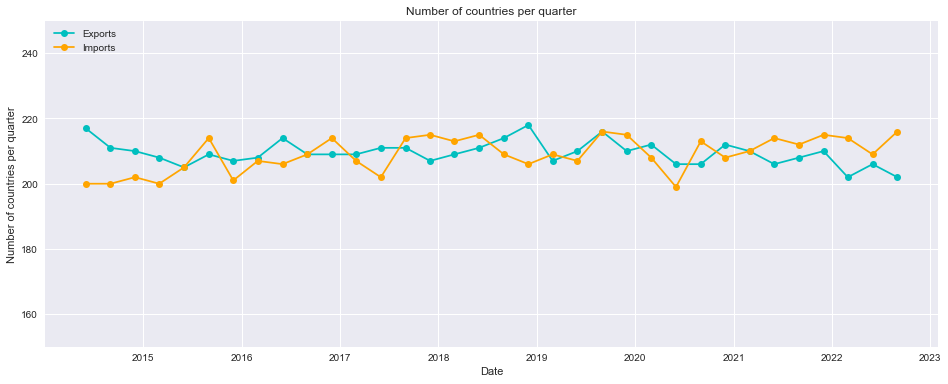

In [9]:
#plot number of countries per quarter

fig,ax = plt.subplots()
line1=ax.plot(countries_perquarter_exp.index, countries_perquarter_exp.values, color = 'c', marker='o',label="Exports")
line2=ax.plot(countries_perquarter_imp.index, countries_perquarter_imp.values, color = 'orange', marker='o', label="Imports")

ax.set_xlabel('Date')
ax.set_title('Number of countries per quarter')
ax.set_ylabel('Number of countries per quarter')
plt.ylim(150,250)
plt.legend(loc='upper left')
plt.show()

In [10]:
#total exports and imports per country

goods_exports_country_total = df[(df["Account"]=='Exports') & (df["Category"]=='Goods')  & (df["Description"]=='Total') & (df["Country"]!='Total all countries')]
goods_imports_country_total = df[(df["Account"]=='Imports') & (df["Category"]=='Goods')  & (df["Description"]=='Total') & (df["Country"]!='Total all countries')]

#subset dataframes
goods_exports_country_total = goods_exports_country_total[["Country Code", "Country", "Total Value (NZD)"]]
goods_imports_country_total = goods_imports_country_total[["Country Code", "Country", "Total Value (NZD)"]]

#transform and rename columns 
goods_exports_country_total["Total Value (NZD)"] = round(goods_exports_country_total["Total Value (NZD)"].div(1000),2)   
goods_exports_country_total.rename(columns={'Country Code':'CountryCode', 'Total Value (NZD)':'ValuesInThousandsNZD'}, inplace = True)   

goods_imports_country_total["Total Value (NZD)"] = round(goods_imports_country_total["Total Value (NZD)"].div(1000),2)   
goods_imports_country_total.rename(columns={'Country Code':'CountryCode', 'Total Value (NZD)':'ValuesInThousandsNZD'}, inplace = True)   

In [11]:
#total exports and imports for all countries

goods_exports_total = df[(df["Account"]=='Exports') & (df["Category"]=='Goods')  & (df["Description"]=='Total') & (df["Country"]=='Total all countries')]
goods_imports_total = df[(df["Account"]=='Imports') & (df["Category"]=='Goods')  & (df["Description"]=='Total') & (df["Country"]=='Total all countries')]

#values of exports and imports in billions $NZ
goods_exports_total = goods_exports_total[['Total Value (NZD)']]
goods_exports_total['Total Value (NZD)'] = round(goods_exports_total['Total Value (NZD)'].div(1000000000),2)
goods_exports_total.rename(columns={'Total Value (NZD)':'ValuesInBillionsNZD'}, inplace = True) 

goods_imports_total = goods_imports_total[['Total Value (NZD)']]
goods_imports_total['Total Value (NZD)'] = round(goods_imports_total['Total Value (NZD)'].div(1000000000),2)
goods_imports_total.rename(columns={'Total Value (NZD)':'ValuesInBillionsNZD'}, inplace = True) 

#### Dataframe of exported and imported services

In [12]:
#create dataframe of services

services_exports= df[(df["Account"]=='Exports') & (df["Category"]=='Services') ]
services_imports= df[(df["Account"]=='Imports') & (df["Category"]=='Services') ]

#size of dataframes
print('Exports of services dataframe:', services_exports.shape, 'Imports of services dataframe:', services_imports.shape)

Exports of services dataframe: (35756, 8) Imports of services dataframe: (28787, 8)


In [13]:
print('Time interval for Services: between' , services_exports.index.min(), 'quarter and ', services_exports.index.max(), 'quarter')

Time interval for Services: between 2014-06-01 00:00:00 quarter and  2022-09-01 00:00:00 quarter


Exported and imported services are labeled as two and four digits A codes. 

In [14]:
#number of countries for each code 

services_exp = services_exports.groupby('Code')['Country'].nunique()
services_imp = services_imports.groupby('Code')['Country'].nunique()
print(pd.merge(services_exp, services_imp, left_on=services_exp.index, right_on=services_imp.index, how='left'))

    key_0  Country_x  Country_y
0     A12        242        240
1   A1202         60         67
2   A1203         61         64
3   A1204        241        234
4   A1205         61         65
5   A1206         54         49
6   A1207        150         74
7   A1208        163        123
8   A1209        178        174
9   A1210        212        210
10  A1211        164        121
11  A1212        234         49


In [15]:
#total exports and imports per country

services_exports_country_total = df[(df["Account"]=='Exports') & (df["Category"]=='Services')  & (df["Description"]=='Total') & (df["Country"]!='Total all countries')]
services_imports_country_total = df[(df["Account"]=='Imports') & (df["Category"]=='Services')  & (df["Description"]=='Total') & (df["Country"]!='Total all countries')]


#subseting dataframes
services_exports_country_total = services_exports_country_total[["Country Code", "Country", "Total Value (NZD)"]]
services_imports_country_total = services_imports_country_total[["Country Code", "Country", "Total Value (NZD)"]]

In [16]:
#total exports and imports per quarters for all countries

services_exports_total = df[(df["Account"]=='Exports') & (df["Category"]=='Services')  & (df["Description"]=='Total') & (df["Country"]=='Total all countries')]
services_imports_total = df[(df["Account"]=='Imports') & (df["Category"]=='Services')  & (df["Description"]=='Total') & (df["Country"]=='Total all countries')]

#values of exports and imports in billions $NZ
services_exports_total = services_exports_total[['Total Value (NZD)']]
services_exports_total['Total Value (NZD)'] = round(services_exports_total['Total Value (NZD)'].div(1000000000),2)
services_exports_total.rename(columns={'Total Value (NZD)':'ValuesInBillionsNZD'}, inplace = True) 

services_imports_total = services_imports_total[['Total Value (NZD)']]
services_imports_total['Total Value (NZD)'] = round(services_imports_total['Total Value (NZD)'].div(1000000000),2)
services_imports_total.rename(columns={'Total Value (NZD)':'ValuesInBillionsNZD'}, inplace = True) 

#### Values of total exports and imports

In [17]:
#Total trades including goods and services

total_trade_exports=services_exports_total.merge(goods_exports_total, left_index=True, right_index=True)
total_trade_imports=services_imports_total.merge(goods_imports_total, left_index=True, right_index=True)

total_trade_exports['ValueOfGoodsandServices'] = total_trade_exports['ValuesInBillionsNZD_x']+ total_trade_exports['ValuesInBillionsNZD_y']
total_trade_imports['ValueOfGoodsandServices'] = total_trade_imports['ValuesInBillionsNZD_x']+ total_trade_imports['ValuesInBillionsNZD_y']

#### Graph of total exports and imports 

The following graph presents the values of exports and imports for Goods and Services and values of the total trades (goods + services).

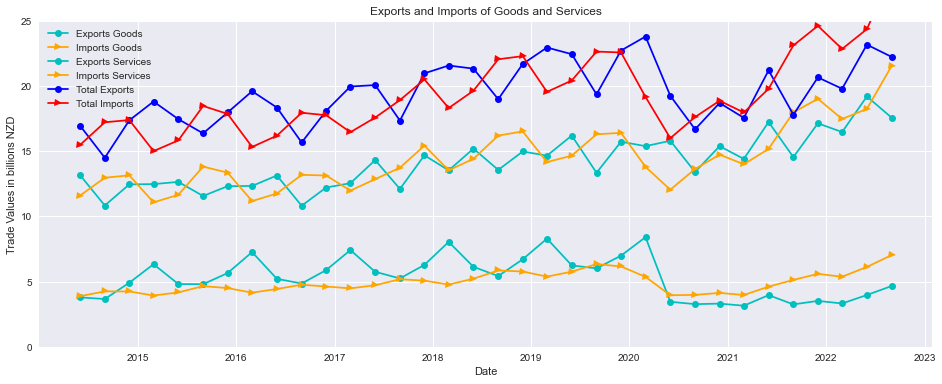

In [18]:
fig,ax = plt.subplots()

line1 = ax.plot(goods_exports_total.index, goods_exports_total.values, color = 'c', marker='o',label="Exports Goods")
line2 = ax.plot(goods_imports_total.index, goods_imports_total.values, color = 'orange', marker='>', label="Imports Goods")
line3 = ax.plot(services_exports_total.index, services_exports_total.values, color = 'c', marker='o',label="Exports Services")
line4 = ax.plot(services_imports_total.index, services_imports_total.values, color = 'orange', marker='>', label="Imports Services")

line5 = ax.plot(total_trade_exports.index, total_trade_exports.ValueOfGoodsandServices, color = 'blue', marker='o', label="Total Exports")
line6 = ax.plot(total_trade_imports.index, total_trade_imports.ValueOfGoodsandServices, color = 'red', marker='>', label="Total Imports")

ax.set_xlabel('Date')
ax.set_title('Exports and Imports of Goods and Services')
ax.set_ylabel('Trade Values in billions NZD')
plt.ylim(0,25)
plt.legend(loc = 'upper left')
plt.show()

#### Exports per country

In [19]:
#maximum exports per quarter and per country

df1 = goods_exports_country_total.groupby(['Quarter', 'Country']).agg({'ValuesInThousandsNZD': sum})
df2 = df1.sort_values('ValuesInThousandsNZD', ascending = 0)

In [20]:
#pivot the table by countries and sort from max to min

goods_exports_country_total_pivot = pd.pivot_table(goods_exports_country_total,
                                    values="ValuesInThousandsNZD",
                                    index="Quarter",
                                    columns="Country",
                                    aggfunc=np.mean)

In [21]:
#Countries with the maximum exports in 2015 

df_temp = goods_exports_country_total_pivot
df_row = df_temp[df_temp.index == df_temp.index[1]].sort_values(by = df_temp.index[1], axis = 1, ascending = False) 


for i in range(2, len(df_temp.index)):
    df_row1 = df_temp[df_temp.index == df_temp.index[i]].sort_values(by = df_temp.index[i], axis = 1, ascending = False)
    dfm = df_row.iloc[:,0:5].append(df_row1.iloc[:,0:5])
    df_row = dfm
    
#dfm_export_goods = dfm.iloc[16:6,]
dfm_export_goods = dfm.loc['20150301' : '20151201']
dfm_export_goods.index = dfm_export_goods.index.strftime('%Y-%m-%d')
print (dfm_export_goods.head(5))

Country      Australia  China, People's Republic of  United States of America  \
Quarter                                                                         
2015-03-01  1935099.33                   2106854.00                1585186.58   
2015-06-01  2038098.70                   2090333.12                1565035.09   
2015-09-01  2137136.95                   1887495.79                1271862.18   
2015-12-01  2229187.94                   2526739.77                1335697.30   

Country         Japan  Korea, Republic of  Indonesia  
Quarter                                               
2015-03-01  674951.46                 NaN        NaN  
2015-06-01  840085.89                 NaN        NaN  
2015-09-01  757100.77           418224.12        NaN  
2015-12-01  680364.84                 NaN        NaN  


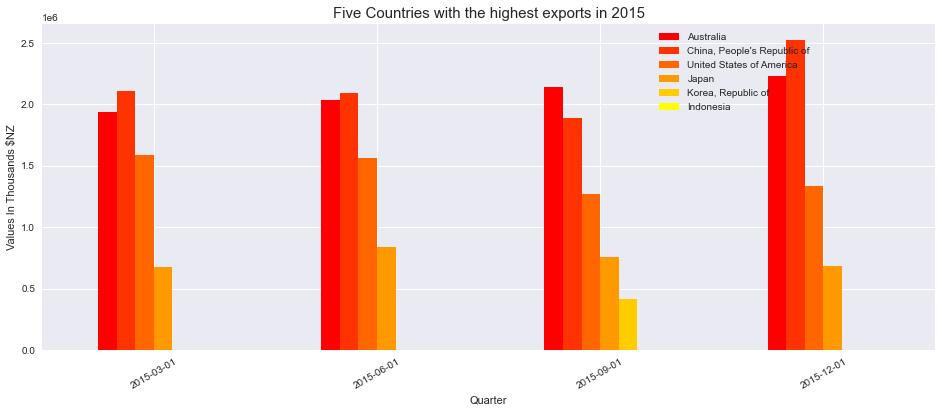

In [22]:
#Four countries with the highest values of exports in 2015

color_map=plt.cm.get_cmap('autumn')
ax = dfm_export_goods.plot(kind='bar', cmap = color_map) 

plt.xticks(rotation=30, horizontalalignment="center")
ax.set_title("Five Countries with the highest exports in 2015", fontsize=15)
ax.set_ylabel("Values In Thousands $NZ")
ax.legend(loc='upper right', bbox_to_anchor=(0.87,1.0))
plt.show()

#### Imports per country

In [23]:
#maximum imports per quarter and per country

df1 = goods_imports_country_total.groupby(['Quarter', 'Country']).agg({'ValuesInThousandsNZD': sum})
df2 = df1.sort_values('ValuesInThousandsNZD', ascending = 0)

In [24]:
#pivot the table by countries and sort from max to min

goods_imports_country_total_pivot = pd.pivot_table(goods_imports_country_total,
                                    values="ValuesInThousandsNZD",
                                    index="Quarter",
                                    columns="Country",
                                    aggfunc=np.mean)

In [25]:
#Four countries with the highest values of exports in 2015

df_temp = goods_imports_country_total_pivot
df_row = df_temp[df_temp.index == df_temp.index[1]].sort_values(by = df_temp.index[1], axis = 1, ascending = False) 


for i in range(2, len(df_temp.index)):
    df_row1 = df_temp[df_temp.index == df_temp.index[i]].sort_values(by = df_temp.index[i], axis = 1, ascending = False)
    dfm = df_row.iloc[:,0:5].append(df_row1.iloc[:,0:5])
    df_row = dfm
    
#dfm_export_goods = dfm.iloc[16:6,]
dfm_import_goods = dfm.loc['20150301' : '20151201']
dfm_import_goods.index = dfm_import_goods.index.strftime('%Y-%m-%d')
print (dfm_import_goods.head(5))

Country     China, People's Republic of  United States of America   Australia  \
Quarter                                                                         
2015-03-01                   2128468.19                1137652.31  1312418.60   
2015-06-01                   2166851.60                1345662.33  1400079.57   
2015-09-01                   2804896.10                1796244.81  1606059.97   
2015-12-01                   2783298.97                1611856.35  1633824.58   

Country         Japan    Germany  Singapore  
Quarter                                      
2015-03-01  713197.78  497857.68        NaN  
2015-06-01  799856.90  552887.99        NaN  
2015-09-01  806929.57  655387.14        NaN  
2015-12-01  823964.93  629059.22        NaN  


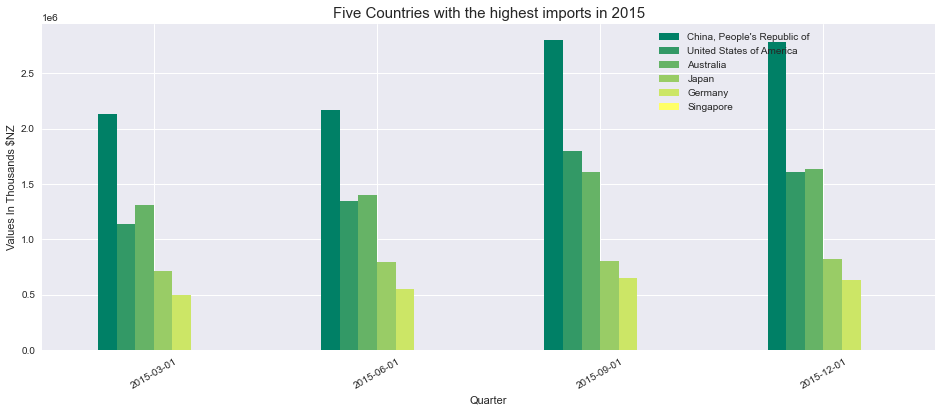

In [26]:
#Bar graph of the highest imports in 2015

color_map=plt.cm.get_cmap('summer')
ax = dfm_import_goods.plot(kind='bar', cmap = color_map) 
plt.xticks(rotation=30, horizontalalignment="center")
ax.set_title("Five Countries with the highest imports in 2015", fontsize=15)
ax.set_ylabel("Values In Thousands $NZ")
ax.legend(loc='upper right', bbox_to_anchor=(0.87,1.0))
plt.show()